In [ ]:
# Importación de librerías que se utilizarán
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Creación de conjuntos de entrenamiento y prueba

In [ ]:
def creacion_dataset(folder):
    
    imagenes = [] # Creacion array de imagenes
    etiquetas = [] # Creacion array de etiquetas
    etiquetas_clases = os.listdir(folder) # Definicion de etiquetas a partir de nombres de carpetas
    
    for etiqueta in etiquetas_clases:
        
        class_path = os.path.join(folder, etiqueta) # Define la ruta de la clase iterada
        if not os.path.isdir(class_path): # Verifica que el folder existe
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name) # Define la ruta de la imagen iterada
            img = cv2.imread(img_path) # Lee la imagen iterada
            if img is not None: # Comprueba que la imagen no es nula 
                img = cv2.resize(img, (64, 64)) # Redimensiona la imagen
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convierte a escala de grises
                img = img.astype("float32") / 255.0 # "Normaliza" la imagen 
                imagenes.append(img.flatten()) # Convierte el arreglo a una dimension y lo agrega al arrelgo imagenes
                etiquetas.append(etiqueta) # Agrega la etiqueta al arreglo de etiquetas
                
    return np.array(imagenes), np.array(etiquetas) # Retorna los arreglos de imagenes y etiquetas

X, Y = creacion_dataset('Direccion carpetas de imagenes') # Llamado de la funcion

le = LabelEncoder() # Se crea el objeto
Y = le.fit_transform(Y) # Se utiliza el metodo fit_transform para reetiquetar el conjunto de etiquetas


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # Creacion conjuntos de entrenamiento y de test

print(f'Tamaño de train: {len(X_train)}, Tamaño de test: {len(X_test)}') # Imprime el tamano de los conjuntos de entrenamiento y de test de las imagenes
print(f'Clases codificadas: {le.classes_}')  # Verifica las clases transformadas

Tamaño de train: 12000, Tamaño de test: 3000
Clases codificadas: ['lung_adenocarcinoma' 'lung_benigno' 'lung_carcinoma']


# Regresión Logística

## Definición modelo y entrenamiento

In [ ]:
log_reg = LogisticRegression(max_iter=3000) # Creacion del objeto Logistic Regression

# Definicion de parametros a probar
param_grid = {"C": [0.01, 0.1, 1, 10, 100], 
              "penalty": ["l2", "none"], 
              "solver":["liblinear", "lbfgs", "saga"]}

# Creacion objeto GridSearchCV con parametros definidos y con 5 CV
grid_search_lrm = GridSearchCV(log_reg, param_grid, cv=5)
# Entrenamiento de posibles modelos
grid_search_lrm.fit(X_train, Y_train)

/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitio

NameError: name 'grid_search' is not defined

In [ ]:
# Imprimir lista de mejores parametros
print("Mejores parametros encontrados: ", grid_search_lrm.best_params_)
# Imprimir precision del modelo con mejores parametros
print("Mejor precision obtenida: ", grid_search_lrm.best_score_)

Mejores parámetros encontrados:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor precisión obtenida:  0.6869166666666666


In [ ]:
# Creación modelo con mejores parámetros
mejor_lr = LogisticRegression(max_iter=3000, C=0.01, penalty="l2", solver="lbfgs")
mejor_lr.fit(X_train, Y_train)

# Evaluación del mejor modelo
y_pred = mejor_lr.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f'Precisión con el mejor C, penalty y solver: {accuracy:.2f}')

Precisión con el mejor C, penalty y solver: 0.68


## Evaluación del modelo

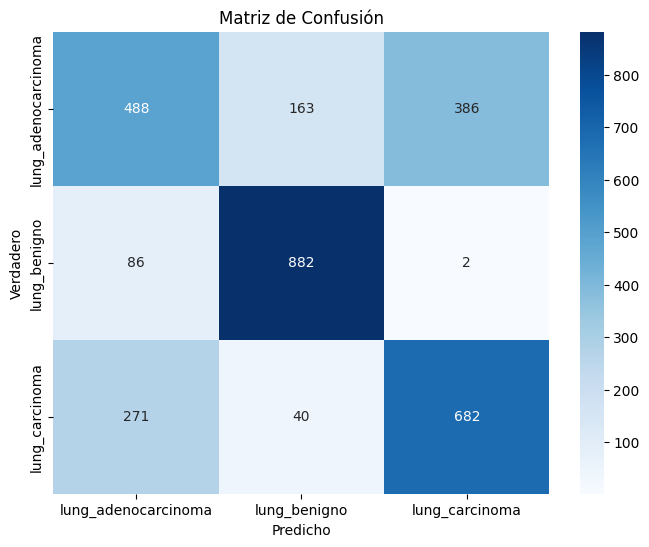

In [ ]:
# Grafiación matriz de confusión

# Crear la matriz de confusión
cm = confusion_matrix(Y_test, y_pred)

class_labels = le.classes_

# Visualizarla con seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Impresión de reporte de clasificación
print(classification_report(Y_test, y_pred, target_names=le.classes_))

                     precision    recall  f1-score   support

lung_adenocarcinoma       0.58      0.47      0.52      1037
       lung_benigno       0.81      0.91      0.86       970
     lung_carcinoma       0.64      0.69      0.66       993

           accuracy                           0.68      3000
          macro avg       0.68      0.69      0.68      3000
       weighted avg       0.67      0.68      0.68      3000



# XGBClassifier

In [ ]:
modelo_XGB = XGBClassifier(device="cuda", random_state=42) # Si no se va a entrenar con GPU, eliminar el parámetro device

param_grid = {
    'n_estimators': [100, 200],  # Numero de arboles
    'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje
    'max_depth': [3, 6, 10],  # Profundidad del arbol
    'subsample': [0.7, 1],  # Proporcion de muestras usadas en cada arbol
    'colsample_bytree': [0.7, 1],  # Proporcion de caracteristicas usadas en cada arbol
    'gamma': [0, 0.1],  # Poda del arbol (reduccion de sobreajuste)
    'reg_alpha': [0, 0.1, 1],  # Regularizacion L1
    'reg_lambda': [1, 10, 100],  # Regularizacion L2
    "device": ["cuda"]  # Habilitar GPU, si no se cuenta con ella, se elimina el parámetro
}

# Creacion objeto GridSearchCV con parametros definidos y con 5 CV
grid_search_XGB = GridSearchCV(modelo_XGB, param_grid, cv=5, verbose=2)  
# Entrenamiento de posibles modelos
grid_search_XGB.fit(X_train, Y_train)

# Evaluar el modelo con los mejores parametros
best_XGB_model = grid_search_XGB.best_estimator_
y_pred = best_XGB_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f'Precisión con los mejores parametros: {accuracy:.2f}')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END colsample_bytree=0.7, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   8.7s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   8.1s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   7.8s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   7.9s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   8.0s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alp

In [ ]:
# Creación modelo con mejores parámetros

mejor_XGB = XGBClassifier(n_estimators = 200,
                          learning_rate = 0.1,
                          max_depth = 10,
                          subsample = 0.7,
                          colsample_bytree = 0.7,
                          gamma = 0.1,
                          reg_alpha = 0.1,
                          reg_lambda = 10,
                          device = "cuda") # Este parámetro se elimina si no se cuenta con GPU
mejor_XGB.fit(X_train, Y_train)

# Evaluación del mejor modelo
y_pred = mejor_XGB.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f'Precisión con los mejores parámetros: {accuracy:.2f}')

c:\Users\Dragut\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [03:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Precisión con los mejores parámetros: 0.90


## Evaluación del modelo

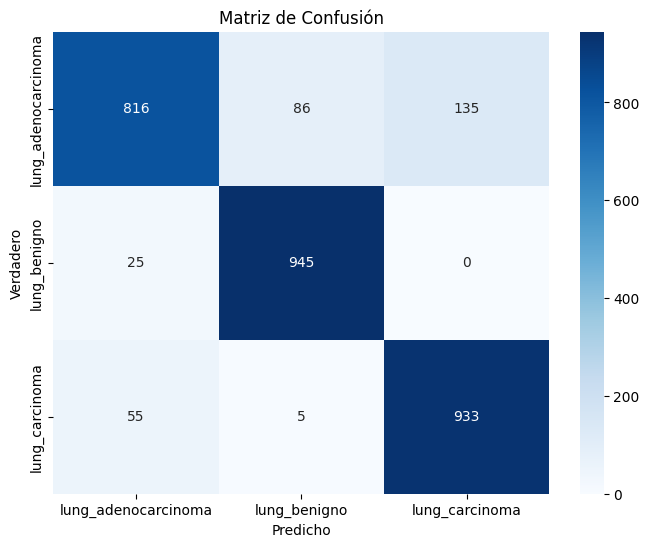

In [ ]:
# Graficación matriz de confusión

# Crear la matriz de confusión
cm = confusion_matrix(Y_test, y_pred)

class_labels = le.classes_

# Visualizarla con seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Impresión de reporte de clasificación
print(classification_report(Y_test, y_pred, target_names=le.classes_))

                     precision    recall  f1-score   support

lung_adenocarcinoma       0.91      0.79      0.84      1037
       lung_benigno       0.91      0.97      0.94       970
     lung_carcinoma       0.87      0.94      0.91       993

           accuracy                           0.90      3000
          macro avg       0.90      0.90      0.90      3000
       weighted avg       0.90      0.90      0.90      3000

